In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

- [x] Предобработка данных
- [x] Анализ данных о регистрациях и займах
- [x] Сколько времени проходит с момента начала регистрации до оформления первого займа
- [x] Срок займа: план-факт + динамика
- [x] Категоризация займов по реальному сроку пользования деньгами
- [x] Исследование суммы займов
- [x] Когортный анализ:
    - [x] User Retention
    - [x] Ср.кол-во займов нарастающим итогом
    - [x] Ср.сумма займа нарастающим итогом
    - [x] ARPU
    - [x] Ретеншен капитала
    - [x] NPL

## Чтение данных и объединение таблиц с данными о регистрациях

In [2]:
# читаем данные
regs = pd.read_excel('regs.xlsx')
loans = pd.read_excel('loans.xlsx')

## Предобработка данных

### Регистрации

In [3]:
# посмотрим на общую информацию
regs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490428 entries, 0 to 490427
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   cid              490428 non-null  int64         
 1   uid              490428 non-null  object        
 2   ts               490428 non-null  datetime64[ns]
 3   is_reg_complete  490428 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 15.0+ MB


In [4]:
# изучим срез данных
regs.sample(5)

,cid,uid,ts,is_reg_complete
91579,1425600,BB24C493-F195-4D2F-8E0B-FFC3B34F703D,2020-09-27 12:34:33.240,1
241893,1121635,76C64CD0-33E1-4009-AF16-8D5A0A48CCB6,2019-06-04 08:05:37.979,1
124954,1244645,E7B834E5-BE95-47C6-B637-45AE311E1211,2019-11-15 08:34:48.572,1
229547,1248989,25527DFA-CDC1-4834-A9E8-1D97DB630981,2019-11-20 10:16:22.887,1
58060,1097128,35E637BF-ABFD-4648-A613-0EBA4E02EBAA,2019-05-22 16:10:21.312,1


<b>cid</b> - id клиента<br>
<b>uid</b> - id юзера<br>
<b>ts</b> - время начала регистрации<br>
<b>is_reg_complete</b> - отметка о завершени регистрации<br>

In [5]:
# uid нам не потребуется в анализе, поэтому просто избавимся от лишней информации
regs.drop(columns=['uid'], inplace=True)

# также приведем к нужному формату данные в ts
regs['ts'] = regs['ts'].astype('datetime64[D]')

# переименуем также один столбец
regs.rename(columns={'ts': 'reg_ts'}, inplace=True)

# проверяем
regs.sample(5)

,cid,reg_ts,is_reg_complete
425350,1411611,2020-09-09,1
151936,1356380,2020-05-10,1
347888,956925,2019-02-13,1
330901,1094071,2019-05-21,1
183161,1349009,2020-03-28,1


In [6]:
# проверим таблицу на наличие пропусков и дубликатов
display(regs.isna().sum())
display(regs.duplicated().sum())

cid                0
reg_ts             0
is_reg_complete    0
dtype: int64

0

<div class="alert alert-block alert-success">
<b>Вывод:</b> пропусков и дублей нет, двигаемся дальше
</div>

### Займы

In [7]:
# посмотрим на общую информацию
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94419 entries, 0 to 94418
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cid       94419 non-null  int64         
 1   uid       94419 non-null  object        
 2   start_ts  86036 non-null  datetime64[ns]
 3   value     94419 non-null  float64       
 4   term      94419 non-null  int64         
 5   status    94419 non-null  object        
 6   end_ts    56292 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 5.0+ MB


In [8]:
# изучим срез данных
loans.sample(5)

,cid,uid,start_ts,value,term,status,end_ts
69331,1341323,E135AB36-847A-43B4-89C0-847CD133BD10,2020-06-09,10900.0,56,Погашен,2020-08-04 23:59:59.999
29736,1058935,CC7359B2-DA25-456B-AB62-6BFC84A883F3,2019-05-28,4000.0,20,На цессии,NaT
43817,1172445,81D31259-BC17-45EE-8EB2-49EB919BA13E,2019-08-20,7276.0,27,Погашен,2019-09-17 23:59:59.999
53650,910241,E0E7A00A-3BB7-4189-8E51-0B64DEEF314D,2019-11-14,3500.0,24,Погашен,2019-12-27 23:59:59.999
87609,1348683,98352C81-90B4-4DE4-AF55-5DF4DED5A1F7,2020-10-08,5000.0,25,Просрочен,NaT


<b>cid</b> - id клиента<br>
<b>uid</b> - id юзера<br>
<b>start_ts</b> - время получения займа<br>
<b>value</b> - сумма<br>
<b>term</b> - срок<br>
<b>status</b> - статус на текущий момент<br>
<b>end_ts</b> - время возврата займа

In [9]:
# uid нам не потребуется в анализе, поэтому просто избавимся от лишней информации
loans.drop(columns=['uid'], inplace=True)

# также приведем к нужному формату данные в столбце end_ts
loans['end_ts'] = loans['end_ts'].astype('datetime64[D]')

# проверяем
loans.sample(5)

,cid,start_ts,value,term,status,end_ts
54708,1170288,2019-11-25,10000.0,10,Погашен,2019-11-25
44416,1172349,NaT,14980.0,40,Отменён,NaT
58086,1188757,2019-12-26,11100.0,30,На цессии,NaT
55148,1171446,2019-11-29,16000.0,56,На цессии,NaT
89289,1370243,2020-10-22,9200.0,56,На реструктуризации,NaT


In [10]:
# проверим таблицу на наличие пропусков и дубликатов
display(loans.isna().sum())
display(loans.duplicated().sum())

cid             0
start_ts     8383
value           0
term            0
status          0
end_ts      38127
dtype: int64

2135

<div class="alert alert-block alert-success">
<b>Вывод:</b> есть пропуски и дубликаты, обработаем их
</div>

In [11]:
# посмотим на стутусы займов с пропущенными значениями в столбце 'start_ts'
loans[loans['start_ts'].isna()]['status'].value_counts()

Отменён           8371
Не подтверждён      12
Name: status, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b> фактически эти статусы говорят о том, что клиент не получил деньги
</div>

In [12]:
# удалим эти строки
loans.dropna(subset=['start_ts'], inplace=True)

# проверяем
loans.isna().sum()

cid             0
start_ts        0
value           0
term            0
status          0
end_ts      29744
dtype: int64

In [13]:
# Посмотрим статусы займов, у которых отсутствуетм время погашения
loans[loans['end_ts'].isna()]['status'].value_counts()

На цессии              17111
Просрочен               8177
Активен                 2354
На реструктуризации     1727
Отменён                  311
Списан                    64
Name: status, dtype: int64

In [14]:
# посмотрим, остались ли дубликаты
loans.duplicated().sum()

0

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>дубли теперь отсутствуют
        <li>пропуски в end_ts фактически указывают на то, что заем не был закрыт на момент анализа данных
    </ul>
</div>
Теперь переходоим к анализу данных

## Аналитика данных

### 1. Анализ данных о регистрациях и займах. Динамика по времени, конверсия + графики

Нам нужна таблица, в которой будут данные в динамике по месяцам:
- Общее кол-во регистраций
- Кол-во успешных (завершенных) регистраций
- Общее кол-во займов
- Кол-во новых займов
- Кол-во повторных займов

#### 1.1 Групиировка данных о регистарциях

In [15]:
# добавим в таблицу regs столбцы: date, week, month - день, неделя и месяц регистрации
regs['reg_date'] = regs['reg_ts'].astype('datetime64[D]')
regs['reg_week'] = regs['reg_ts'].dt.to_period('W').apply(lambda r: r.start_time)
regs['reg_month'] = regs['reg_ts'].astype('datetime64[M]')

# проверяем
regs.head()

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month
0,1180314,2019-07-23,1,2019-07-23,2019-07-22,2019-07-01
1,1169902,2019-07-14,1,2019-07-14,2019-07-08,2019-07-01
2,939190,2019-02-06,1,2019-02-06,2019-02-04,2019-02-01
3,1135293,2019-06-14,1,2019-06-14,2019-06-10,2019-06-01
4,979757,2019-02-27,1,2019-02-27,2019-02-25,2019-02-01


In [16]:
# сгруппируем данные по месяцам, посчитаем общее кол-во регистраци и кол-во успешных регистраций
regs_by_month = regs.groupby(by='reg_month').agg({'cid': 'nunique', 'is_reg_complete': 'sum'})
regs_by_month.columns = ['total_regs', 'success_regs']

# смотрим
regs_by_month

,total_regs,success_regs
reg_month,,
2019-01-01,37669,31651
2019-02-01,45059,38293
2019-03-01,39752,33366
2019-04-01,41598,30584
2019-05-01,41689,30134
2019-06-01,33410,23810
2019-07-01,32892,24006
2019-08-01,10192,7860
2019-09-01,4843,3920


#### 1.2 Групиировка данных о займах

In [17]:
# у нас уже есть сгруппированные по месяцам данные о регистрациях, теперь тоже самое нужно сделать с займами
# но для начала - добавить в таблицу loans столбцы: date, week, month - день, неделя и месяц регистрации

loans['loan_date'] = loans['start_ts'].dt.date
loans['loan_week'] = loans['start_ts'].dt.to_period('W').apply(lambda r: r.start_time)
loans['loan_month'] = loans['start_ts'].astype('datetime64[M]')

# проверяем
loans.head()

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month
0,888862,2019-01-01,5000.0,30,Погашен,2019-01-02,2019-01-01,2018-12-31,2019-01-01
1,888862,2019-01-13,2500.0,7,Погашен,2019-01-13,2019-01-13,2019-01-07,2019-01-01
2,888862,2019-01-14,2500.0,30,Погашен,2019-01-31,2019-01-14,2019-01-14,2019-01-01
3,888862,2019-02-12,4700.0,30,Погашен,2019-02-15,2019-02-12,2019-02-11,2019-02-01
4,888862,2019-02-18,3000.0,30,Погашен,2019-02-21,2019-02-18,2019-02-18,2019-02-01


In [18]:
# для начала для каждого юзера найдем месяц первого займа
new_loans_by_month = loans.sort_values(by=['cid', 'start_ts']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# теперь сгруппируем данные по месяцам и подсчитаем кол-во уникальны займов
new_loans_by_month = new_loans_by_month.groupby(by='loan_month').agg({'cid': 'count'})
new_loans_by_month.columns = ['new_loans']

# проверяем
new_loans_by_month

,new_loans
loan_month,
2019-01-01,4540
2019-02-01,4969
2019-03-01,2976
2019-04-01,3043
2019-05-01,2480
2019-06-01,1391
2019-07-01,3209
2019-08-01,1852
2019-09-01,1345


In [19]:
# теперь посчитаем общее кол-во займов по месяцам
total_loans_by_month = loans.groupby(by='loan_month').agg({'cid': 'count'})
total_loans_by_month.columns = ['total_loans']

# проверяем
total_loans_by_month

,total_loans
loan_month,
2019-01-01,5434
2019-02-01,7152
2019-03-01,6199
2019-04-01,5814
2019-05-01,4955
2019-06-01,3251
2019-07-01,4777
2019-08-01,3477
2019-09-01,3016


In [20]:
# объеденим таблицы total_loans_by_month и new_loans_by_month
loans_by_month = pd.merge(total_loans_by_month, new_loans_by_month, on='loan_month')

# рассчитаем кол-во повторных займов
loans_by_month['repeated_loans'] = loans_by_month['total_loans'] - loans_by_month['new_loans']

# проверяем
loans_by_month

,total_loans,new_loans,repeated_loans
loan_month,,,
2019-01-01,5434,4540,894
2019-02-01,7152,4969,2183
2019-03-01,6199,2976,3223
2019-04-01,5814,3043,2771
2019-05-01,4955,2480,2475
2019-06-01,3251,1391,1860
2019-07-01,4777,3209,1568
2019-08-01,3477,1852,1625
2019-09-01,3016,1345,1671


#### 1.3 Объеденение данных в обну таблицу

In [21]:
total_grouped_data = pd.merge(regs_by_month, loans_by_month, left_index=True, right_index=True)

total_grouped_data

,total_regs,success_regs,total_loans,new_loans,repeated_loans
2019-01-01,37669,31651,5434,4540,894
2019-02-01,45059,38293,7152,4969,2183
2019-03-01,39752,33366,6199,2976,3223
2019-04-01,41598,30584,5814,3043,2771
2019-05-01,41689,30134,4955,2480,2475
2019-06-01,33410,23810,3251,1391,1860
2019-07-01,32892,24006,4777,3209,1568
2019-08-01,10192,7860,3477,1852,1625
2019-09-01,4843,3920,3016,1345,1671
2019-10-01,20404,16224,2316,1287,1029


#### 1.4 Графики

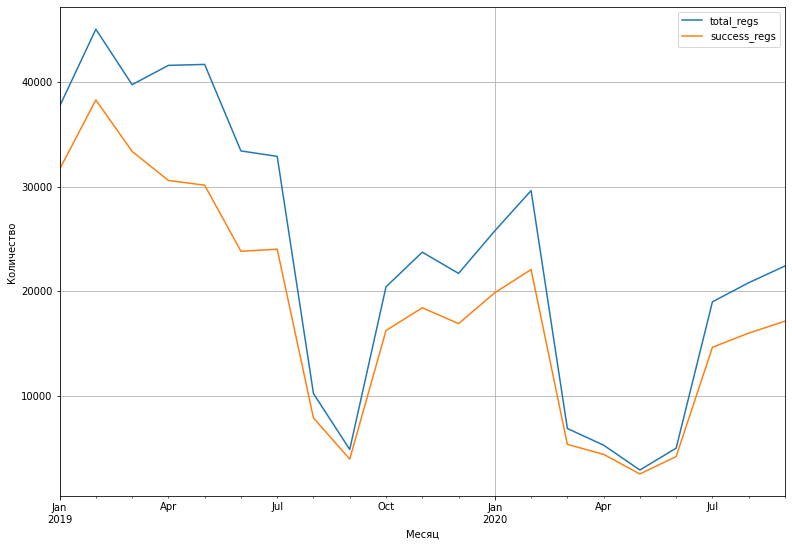

In [22]:
# построим график динамики регистраций по месяцам
total_grouped_data[['total_regs', 'success_regs']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

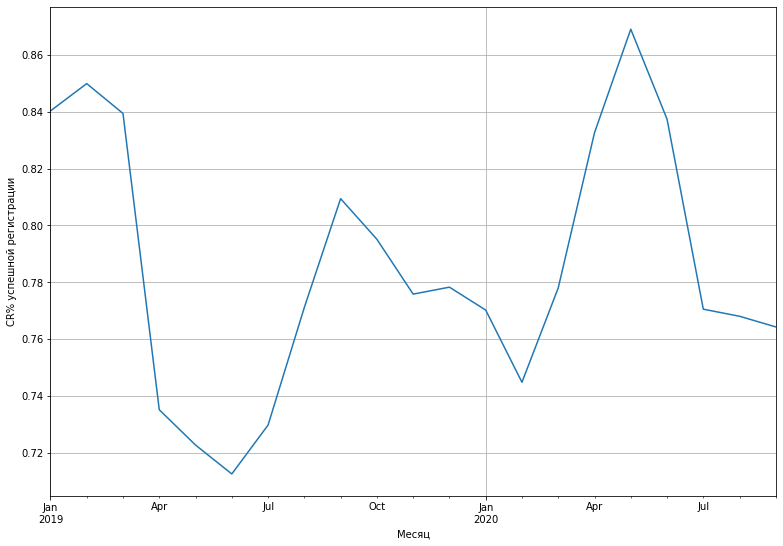

In [23]:
# а также ихучим конверсию из всех регистраций в успешные
(total_grouped_data['success_regs'] / total_grouped_data['total_regs']).plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('CR% успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>количетсво регистраций (всех/успешных) стабильно сокращалось с апрелья 2019 года
        <li>при этом конверсия в успешную регистрацию за этот же период показала стабильный рост и достигла порядка 70%
    </ul>
</div>

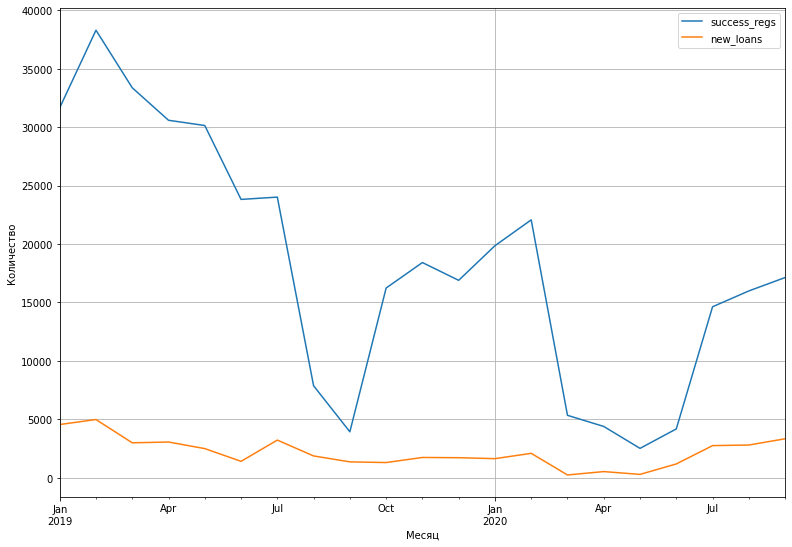

In [24]:
# теперь на одном графике сравним динамику успешных регистраций и новых займов
total_grouped_data[['success_regs', 'new_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

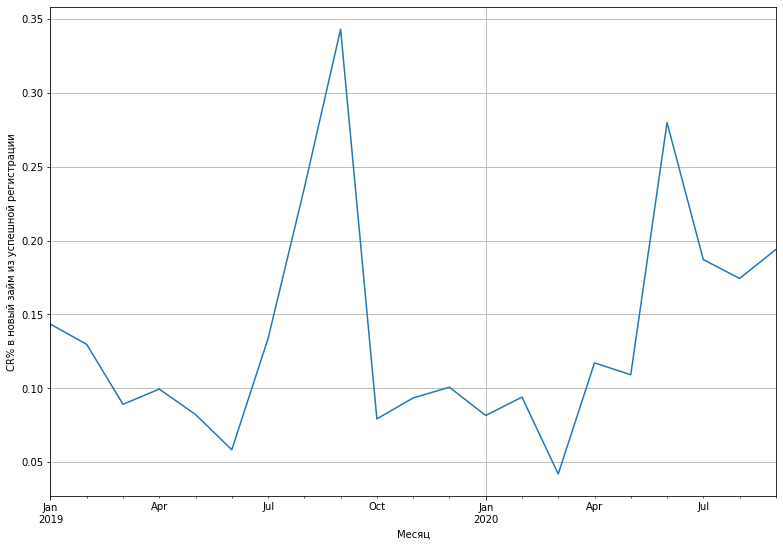

In [25]:
# а также посмотрим на конверсию в динамике
(total_grouped_data['new_loans'] / total_grouped_data['success_regs']).plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('CR% в новый займ из успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>при стабильном сокращении успешных регистраций кол-во новых займов осталось практически на том же уровне
        <li>можно констатировать, что произошло это в первую очередь за счет роста конверсии в новый заем с 15% до 25%
        <li>однако это общие данные, которые состаят из различных источников трафика в тч высококонверсионной органики (в тч брендовой). Судя по данным из affise CPA канал в августе имел CR = 17%
    </ul>
</div>

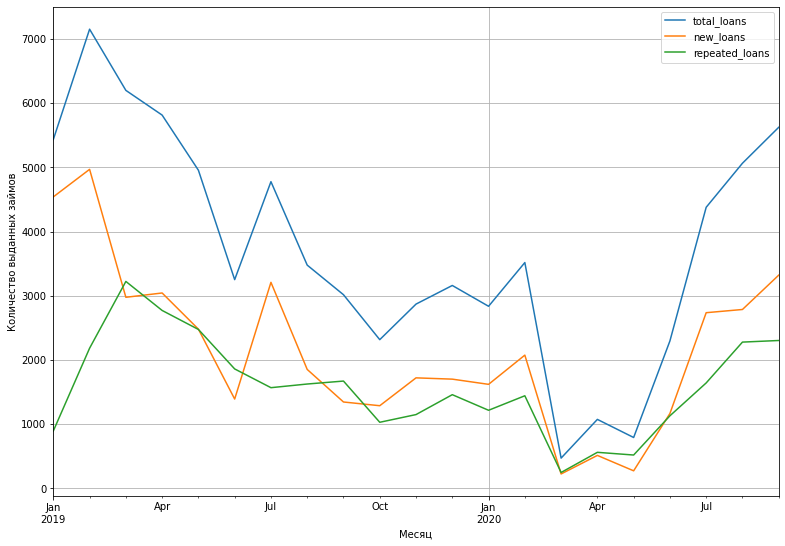

In [26]:
# посмотрим на долю потворных займов в динамике
total_grouped_data[['total_loans', 'new_loans', 'repeated_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество выданных займов');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>ближе к концу анализируемого периода наблюдается рост общего количества выданных займов
        <li>происходит это за счет роста повторных выдач. Это хороший для нас показатель
        <li>доля вопвторных займов колеблется в диапазоне 60%-70%
    </ul>
</div>

### 2. Сколько времени проходит с момента начала регистрации до оформления первого займа

In [27]:
# для начала из таблицы loans нам нужно получить для каждого юзера данные о его первом займе
first_loan_ts = loans.sort_values(by=['cid', 'start_ts']).groupby(by='cid').agg({'start_ts': 'first'}).reset_index()
first_loan_ts.columns=['cid', 'start_loan']

# проверяем
first_loan_ts.head()

,cid,start_loan
0,888862,2019-01-01
1,888868,2019-01-01
2,888872,2019-01-12
3,888882,2019-01-01
4,888884,2019-01-01


In [28]:
# теперь добавим эти данные в таблицу с регистрациями
time_to_loan = pd.merge(regs, first_loan_ts, how='left', on='cid')

# посмотрим на случайные 20 записей из получившейся таблицы
time_to_loan.sample(20)

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month,start_loan
128800,1367565,2020-07-09,1,2020-07-09,2020-07-06,2020-07-01,NaT
465959,1016645,2019-03-27,0,2019-03-27,2019-03-25,2019-03-01,NaT
380927,1085747,2019-05-18,1,2019-05-18,2019-05-13,2019-05-01,2019-05-20
54645,1007092,2019-03-20,1,2019-03-20,2019-03-18,2019-03-01,NaT
406220,1085961,2019-05-18,0,2019-05-18,2019-05-13,2019-05-01,NaT
402283,981504,2019-03-01,1,2019-03-01,2019-02-25,2019-03-01,NaT
367847,1130076,2019-06-10,0,2019-06-10,2019-06-10,2019-06-01,NaT
40907,1278944,2019-12-26,1,2019-12-26,2019-12-23,2019-12-01,2020-02-25
255663,1386232,2020-08-07,0,2020-08-07,2020-08-03,2020-08-01,NaT
16454,1007898,2019-03-21,0,2019-03-21,2019-03-18,2019-03-01,NaT


<div class="alert alert-block alert-info">
<b>Важно:</b> во многих строках столбца start_loan появились значения NaT. Это говорит о том, что клиент начал регистрацию, но в итоге ни одного займа не получил. Избавимся от этих строк</div>

In [29]:
# удаляем лишние строки
time_to_loan.dropna(subset=['start_loan'], inplace=True)

In [30]:
# добавим в таблицу новый столбец с кол-во дней с начала регистрации до первого займа
time_to_loan['days_to_loan'] = (time_to_loan['start_loan'] - time_to_loan['reg_ts']).dt.days

time_to_loan.sample(10)

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month,start_loan,days_to_loan
90553,932616,2019-02-02,1,2019-02-02,2019-01-28,2019-02-01,2019-02-02,0
447229,1244323,2019-11-14,1,2019-11-14,2019-11-11,2019-11-01,2019-11-14,0
403442,921993,2019-01-26,1,2019-01-26,2019-01-21,2019-01-01,2019-01-26,0
223575,1110710,2019-05-28,1,2019-05-28,2019-05-27,2019-05-01,2019-06-13,16
403226,1031983,2019-04-08,1,2019-04-08,2019-04-08,2019-04-01,2019-07-08,91
102499,1242460,2019-11-12,1,2019-11-12,2019-11-11,2019-11-01,2019-11-13,1
393681,1413987,2020-09-12,1,2020-09-12,2020-09-07,2020-09-01,2020-09-12,0
211722,1051103,2019-04-16,1,2019-04-16,2019-04-15,2019-04-01,2019-04-19,3
239696,1192051,2019-08-04,1,2019-08-04,2019-07-29,2019-08-01,2019-08-04,0
271568,980600,2019-02-28,1,2019-02-28,2019-02-25,2019-02-01,2019-03-01,1


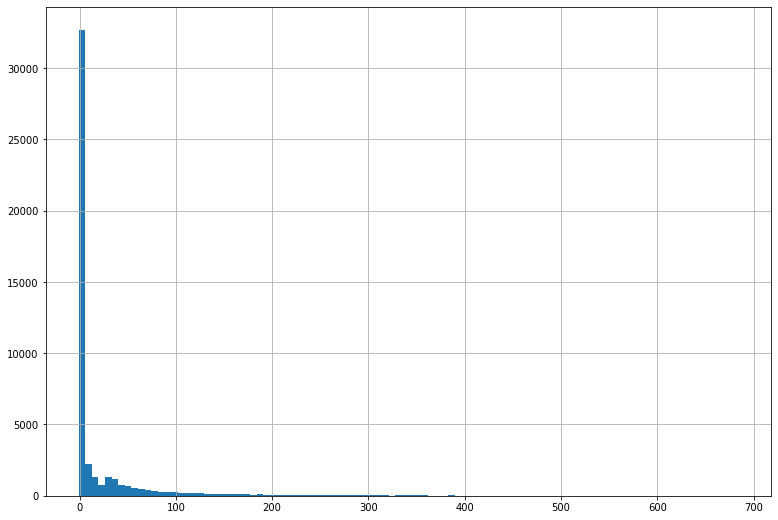

In [31]:
# построим гистограмму
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=100);

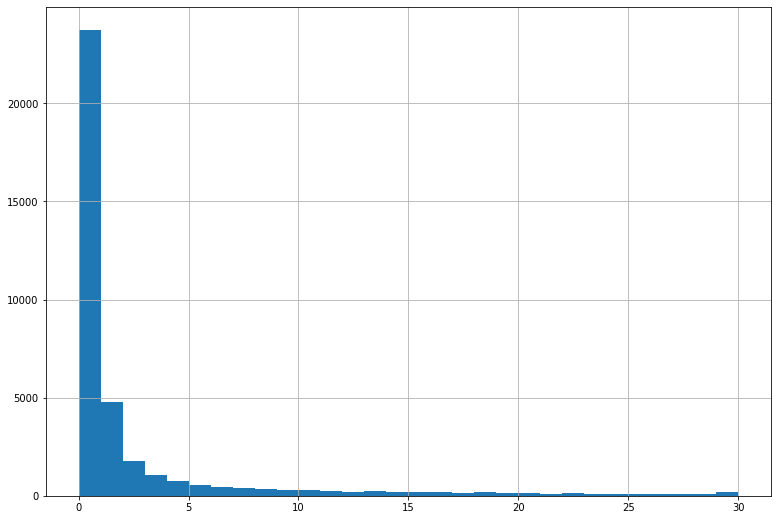

In [32]:
# львиная доля значений лежит в диапазоне от 0 до 30 дней, ограничим гистограмму этими значениями
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=30, range=(0, 30));

In [33]:
# посмотрим на ТОП10 значений
time_to_loan['days_to_loan'].value_counts().head(10)

0     23740
1      4796
2      1793
3      1053
4       732
5       554
6       444
7       375
31      366
8       340
Name: days_to_loan, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>львиная доля клиентов получают свой первый заем в день регистрации
        <li>кол-во выдач на следующий день относительно большое, но это в т.ч. может быть связано с займами, которые оформляются в вечернее время и выдаются уже на следующий день
        <li>есть небольшой скачок на 32 день. Скорее всего это связано с разблокировкой спустя 30 дней
        <li>чем дальше от времени регистрации тем меньше шанс, что клиент оформит свой первый заем
        <li>в качестве рекомендации - нужно стараться максимально быстро конвертировать регистрацию в первый заем
    </ul>
</div>

### 3. Исследвание срока займа (план, факт) + динамика по месяцам

#### 3.1 Запрашиваемые и фактические значения займов

In [34]:
# рассчитаем фактический срок пользования деньгами
loans['real_term'] = (loans['end_ts'] - loans['start_ts']).dt.days

# удалим пустые значения т.к. нам нужны только те займы, которые уже погашены и сохраним данные в отдельный датафрейм
real_term = loans.query('real_term.notna()')
real_term['real_term'] = real_term['real_term'].astype('int')

# проверим на выборке
real_term.sample(10)

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term
3866,903210,2019-02-19,18000.0,23,Погашен,2019-02-28,2019-02-19,2019-02-18,2019-02-01,9
18204,995442,2019-03-16,9800.0,23,Погашен,2019-04-18,2019-03-16,2019-03-11,2019-03-01,33
16890,985093,2019-03-05,16500.0,23,Погашен,2019-03-09,2019-03-05,2019-03-04,2019-03-01,4
24678,979302,2019-04-28,2000.0,20,Погашен,2019-05-18,2019-04-28,2019-04-22,2019-04-01,20
10722,938384,2019-03-11,6500.0,30,Погашен,2019-04-10,2019-03-11,2019-03-11,2019-03-01,30
42251,1200005,2019-08-13,12840.0,40,Погашен,2019-09-18,2019-08-13,2019-08-12,2019-08-01,36
58735,1233774,2020-01-03,5000.0,10,Погашен,2020-01-03,2020-01-03,2019-12-30,2020-01-01,0
78675,1392918,2020-08-19,11000.0,40,Погашен,2020-11-27,2020-08-19,2020-08-17,2020-08-01,100
1701,894639,2019-02-11,17000.0,30,Погашен,2019-03-13,2019-02-11,2019-02-11,2019-02-01,30
33515,1134435,2019-06-22,5350.0,10,Погашен,2019-07-02,2019-06-22,2019-06-17,2019-06-01,10


In [35]:
# сравним сумму дней из запросов пользователей с суммой фактических дней пользования кредитом
print(f'Всего займов было оформлено на {real_term["term"].sum():,} дня(ей)')
print(f'Фактически с учетом досрочных погашений и просрочек деньгами пользовались {real_term["real_term"].sum():,} дня(ей)')

Всего займов было оформлено на 1,617,551 дня(ей)
Фактически с учетом досрочных погашений и просрочек деньгами пользовались 2,009,135 дня(ей)


<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> Суммарный фактичесий срок пользования деньгами на 10,5% (или 862,699 дней) больше, чем все суммарные запрошенные значения. Это даже с учетом займов, которые погашаются досрочно (спойлер: их достаточно много)
    </ul>
</div>

count    56292.000000
mean        28.735007
std         14.201437
min          1.000000
25%         20.000000
50%         30.000000
75%         35.000000
max        168.000000
Name: term, dtype: float64

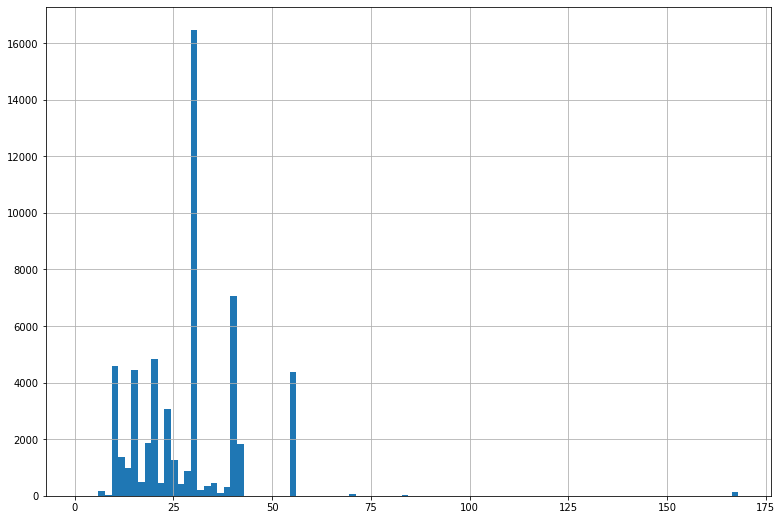

In [36]:
# распределение запрашиваемых сроков займов
display(real_term['term'].describe())
real_term['term'].hist(bins=100, figsize=(13, 9));

#### 3.2 Распределение показателей, среднее значение, медиана, мода

count    56292.000000
mean        35.691306
std         40.965767
min          0.000000
25%         10.000000
50%         24.000000
75%         45.000000
max        656.000000
Name: real_term, dtype: float64

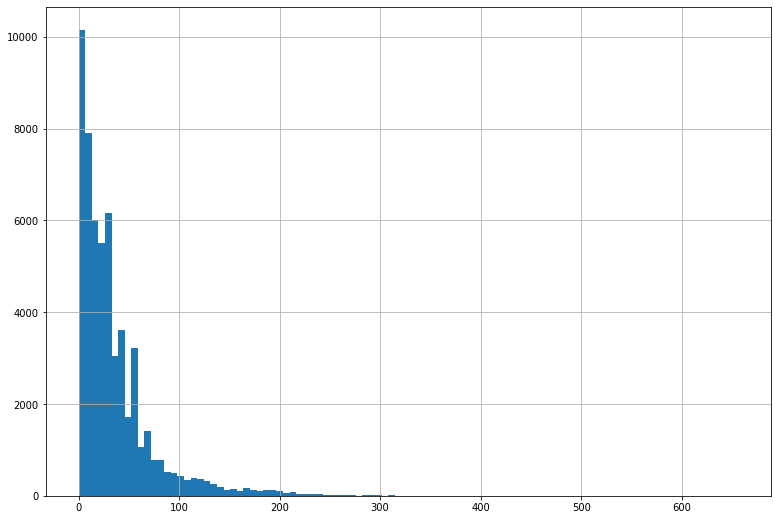

In [37]:
# распределение фактических сроков пользования займом
display(real_term['real_term'].describe())
real_term['real_term'].hist(bins=100, figsize=(13, 9));

In [38]:
# ТОП5 запрашиваемых сроков
real_term['term'].value_counts().head()

30    15909
40     7048
56     4386
10     4226
20     3993
Name: term, dtype: int64

In [39]:
# ТОП5 фактических сроков
real_term['real_term'].value_counts().head()

30    1850
1     1845
0     1821
56    1743
10    1498
Name: real_term, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>графики распределения отличаются очень сильно. Это говорит о том, что то, как люди планируют возвращать деньги и то, как они их возвращают - это разные значения
        <li>также на распределение оказывает влияение то, что запрашиваемый срок займа строго ограничен
        <li>среднее значение фактического пользования займом = 32.66 дня, средний запрашиваемый срок = 29.55 дня
        <li>медианное значение больше уже у запрашиваемых показателй - 30 дней против 20 дней. Т.е. 50% займов закрываются в срок до 20 дней
        <li>в ТОП5 значений фактического пользования займами есть 2 не очень хороших значения - это 0 день (погашение в день получения займа) и 1 (погашение на следующий день)
        <li>25% займов погашаются до 8 дней, 50% до 20 дней, 75% до 42 дней. Над этими показателями стоило бы поработать
    </ul>
</div>

#### 3.3 Динамка планового и фактического срока пользования деньгами

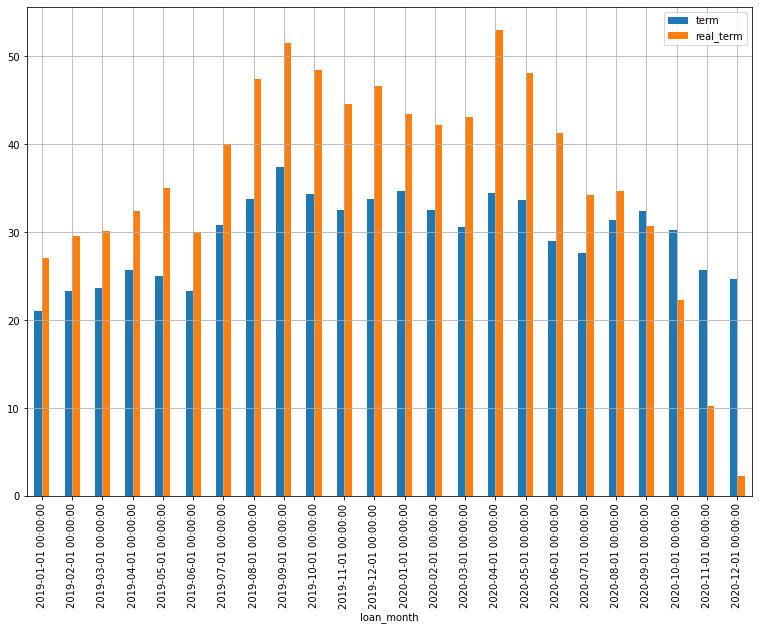

In [40]:
real_term.groupby('loan_month').agg({'term': 'mean', 'real_term': 'mean'}).plot(kind='bar', figsize=(13, 9), grid=True);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>весь 2019 год средний срок пользовния деньгами показывал положительную динамику
        <li>в этот же период мы видим значительно большой рост факт.пользования отностилеьно плана
        <li>начиная с июля график идет вниз, но это скорее всего связано с тем, что часть клиентов из просрочки еще не вернули деньги (но согласно статистике обязательно вернут) либо доля досрочных погашений выросла
        <li>в дальнейшем посомотрим еще на эти показатели в когортах
    </ul>
</div>

### 4. Категоризация займов по реальному сроку пользования деньгами

In [41]:
# созданим функцию категоризации срока закрытия займа
def set_term_category(row):
    if row['real_term'] == row['term']:
        return 'В срок'
    elif row['real_term'] < row['term']:
        return 'Досрочно'
    elif row['real_term'] > row['term']:
        return 'С просрочкой'
    return 'Не закрыт'

In [42]:
# применяем функцию
loans['term_category'] = loans.apply(set_term_category, axis=1)

# проверяем
loans.sample(10)

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term,term_category
82634,1411163,2020-09-10,9200.0,42,Погашен,2020-12-03,2020-09-10,2020-09-07,2020-09-01,84.0,С просрочкой
1376,893558,2019-02-19,20000.0,30,Погашен,2019-02-24,2019-02-19,2019-02-18,2019-02-01,5.0,Досрочно
16310,981603,2019-03-01,14700.0,29,Погашен,2019-05-23,2019-03-01,2019-02-25,2019-03-01,83.0,С просрочкой
47992,1048327,2019-09-13,17440.0,40,На цессии,NaT,2019-09-13,2019-09-09,2019-09-01,NaN,Не закрыт
46579,1136925,2019-09-03,8560.0,40,Погашен,2019-09-05,2019-09-03,2019-09-02,2019-09-01,2.0,Досрочно
86988,1384668,2020-10-03,4500.0,30,Погашен,2020-11-03,2020-10-03,2020-09-28,2020-10-01,31.0,С просрочкой
83423,1118592,2020-09-14,17250.0,56,Погашен,2020-11-09,2020-09-14,2020-09-14,2020-09-01,56.0,В срок
79871,1398775,2020-08-25,8400.0,10,Погашен,2020-09-21,2020-08-25,2020-08-24,2020-08-01,27.0,С просрочкой
80846,1403175,2020-08-31,9200.0,56,Погашен,2020-10-26,2020-08-31,2020-08-31,2020-08-01,56.0,В срок
19961,942087,2019-04-08,18000.0,20,Погашен,2019-04-23,2019-04-08,2019-04-08,2019-04-01,15.0,Досрочно


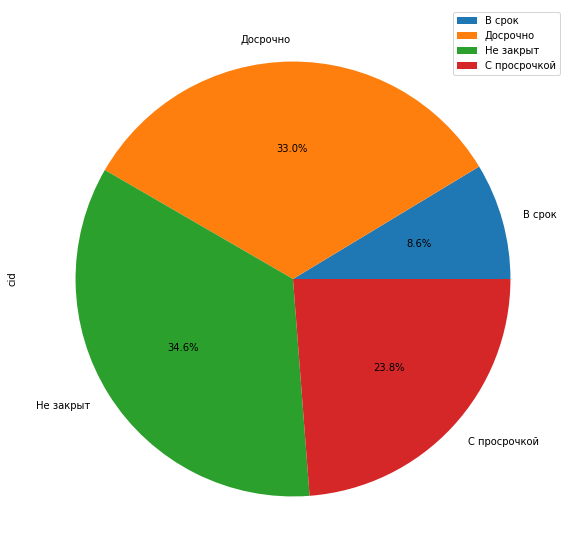

In [43]:
# построим круговую диаграмму для визуализации разделения займов по типам погашения
loans.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

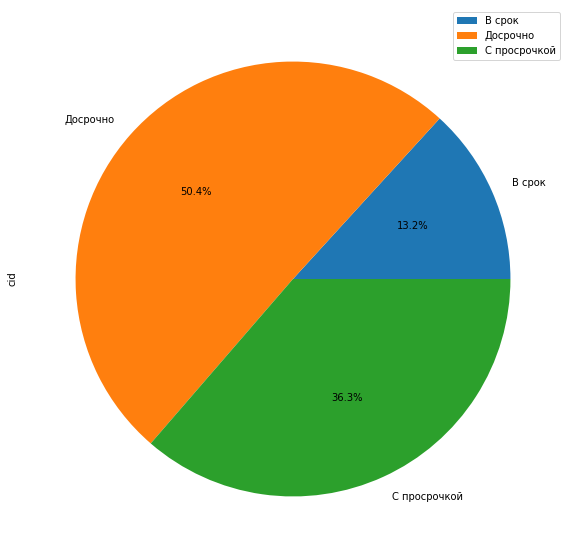

In [44]:
# та же диаграмма, но без статуса "Не закрыт"
loans.query('term_category != "Не закрыт"')\
.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>27.4% не закрытых займов - цифра немного преувеличенная т.к. чем ближе анализируемый месяц к текущему - тем больше % невозвратов и наоборот.
        <li>Если анализировать уже закрытые займы - 55.6% досрочно закрытых займов это большая цифра. И это как раз точка роста
    </ul>
</div>

### 4. Исследование суммы займов

#### 4.1 Базовые данные о сумме займов

In [45]:
print(f'Суммарные выдачи за анализируемый период составили {loans["value"].sum():,} рублей')

Суммарные выдачи за анализируемый период составили 885,714,791.0 рублей


In [46]:
# посмотрим на среднее, медиану, квартили и другие значения
loans['value'].describe()

count    86036.000000
mean     10294.699788
std       5884.172509
min         10.000000
25%       5000.000000
50%       9500.000000
75%      14500.000000
max      80500.000000
Name: value, dtype: float64

In [47]:
# TOP10 частотность
loans['value'].value_counts().head(10)

20000.0    5071
10000.0    4431
8000.0     3823
4000.0     3649
12000.0    3474
5000.0     2917
3500.0     2843
6500.0     2620
17000.0    2160
14000.0    2127
Name: value, dtype: int64

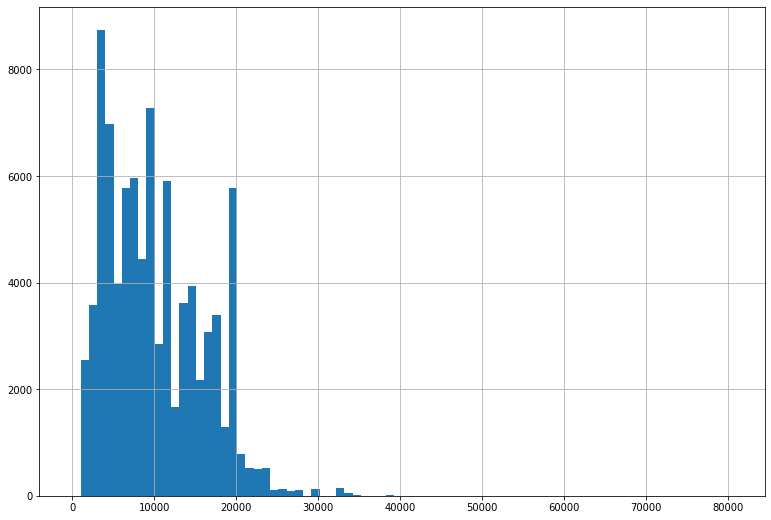

In [48]:
# посмотрим на распределение
loans['value'].hist(figsize=(13, 9), bins=80);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>общая сумма выданных средств за анализируемый период 3 683 503 741 рубля
        <li>средняя выдача - 9648 рублей
        <li>первый-третий квартили: 4500, 8000, 12000. Это значит, что 25% займов оформляются на сумму, меньше 4500р, 50% займов на сумму до 8000 и 75% займов на сумму до 12000 рублей.
        <li>чаще всего берут займ на 8000 рублей (28526 раз)
        <li>в ТОП10 значений по частоте 7 значений меньше 10000 рублей
    </ul>
</div>

#### 4.2 Динамика измениня средней суммы займа

In [49]:
# группируем данные по месяцам, для каждого месяца считаем суммарный объем займов и количество займов
avg_loan_value = loans.groupby('loan_month').agg({'value': 'sum', 'cid': 'count'})

# переименуюем столбцы
avg_loan_value.columns=['total_value', 'total_loans']

# посчитаем средний чек
avg_loan_value['avg_loan_value'] = (avg_loan_value['total_value'] / avg_loan_value['total_loans']).astype('int')

avg_loan_value

,total_value,total_loans,avg_loan_value
loan_month,,,
2019-01-01,57294800.0,5434,10543
2019-02-01,75760700.0,7152,10592
2019-03-01,69721600.0,6199,11247
2019-04-01,65064510.0,5814,11191
2019-05-01,56200177.0,4955,11342
2019-06-01,32425843.0,3251,9974
2019-07-01,45933287.0,4777,9615
2019-08-01,37375477.0,3477,10749
2019-09-01,36738529.0,3016,12181


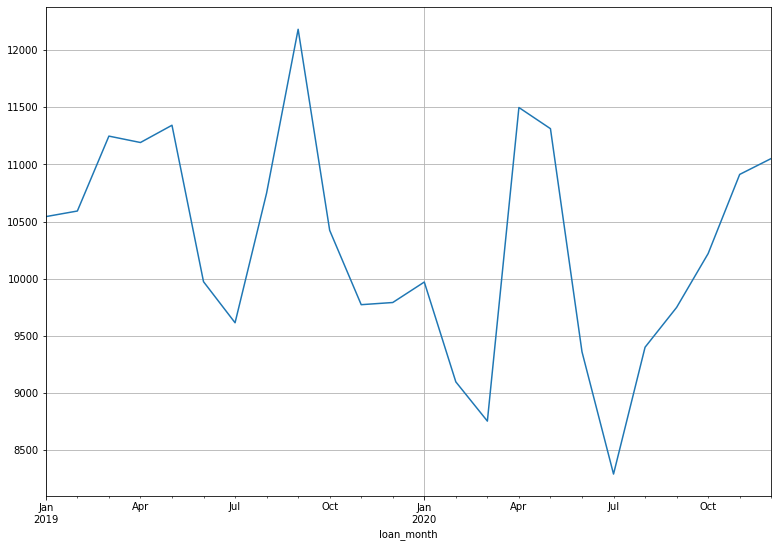

In [50]:
# посмотрим на чек в динамике
avg_loan_value['avg_loan_value'].plot(figsize=(13, 9), grid=True);

In [51]:
print(f'Минимальное занчение {avg_loan_value["avg_loan_value"].min()} рубл.')
print(f'Максимальное занчение {avg_loan_value["avg_loan_value"].max()} руб.')

Минимальное занчение 8292 рубл.
Максимальное занчение 12181 руб.


<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>мин-макс средние значения находятся в диапазоне от 8154 руб до 10672 руб
        <li>не прослеживается какой-либо тренд на рост-падение, есть только периодические колебания на 10-20%
    </ul>
</div>

### 5. Когортный анализ

#### 5.1 Ретеншен

In [52]:
# для начала нам нужно выделить в отдельную таблицу месяц первого займа для каждого пользователя
loan_first_month = loans.sort_values(by=['cid', 'loan_month']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# переименуем столбцы
loan_first_month.columns = ['cid', 'loan_first_month']

# смотрим на результат
loan_first_month

,cid,loan_first_month
0,888862,2019-01-01
1,888868,2019-01-01
2,888872,2019-01-01
3,888882,2019-01-01
4,888884,2019-01-01
...,...,...
46918,1429742,2020-10-01
46919,1429747,2020-11-01
46920,1429754,2020-11-01
46921,1429758,2020-10-01


In [53]:
# объеденим таблицы loans vs loan_first_month
loans = pd.merge(loans, loan_first_month, on='cid')

# добавим в таблицу столбец cohort_lifetime, который указывает на срок жизни когорты в месяцах
loans['cohort_lifetime'] =((loans['loan_month'] - loans['loan_first_month']) / np.timedelta64(1,'M'))\
.round().astype('int')

# смотрим на результат
loans.head()

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term,term_category,loan_first_month,cohort_lifetime
0,888862,2019-01-01,5000.0,30,Погашен,2019-01-02,2019-01-01,2018-12-31,2019-01-01,1.0,Досрочно,2019-01-01,0
1,888862,2019-01-13,2500.0,7,Погашен,2019-01-13,2019-01-13,2019-01-07,2019-01-01,0.0,Досрочно,2019-01-01,0
2,888862,2019-01-14,2500.0,30,Погашен,2019-01-31,2019-01-14,2019-01-14,2019-01-01,17.0,Досрочно,2019-01-01,0
3,888862,2019-02-12,4700.0,30,Погашен,2019-02-15,2019-02-12,2019-02-11,2019-02-01,3.0,Досрочно,2019-01-01,1
4,888862,2019-02-18,3000.0,30,Погашен,2019-02-21,2019-02-18,2019-02-18,2019-02-01,3.0,Досрочно,2019-01-01,1


In [54]:
# создадим новую таблицу retention и сгруппируем в нее данные из таблицы loans
retention = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'nunique'}).reset_index()

# переименуем колонки
retention.columns = ['loan_first_month', 'cohort_lifetime', 'active_users']

# смотрим результат
retention

,loan_first_month,cohort_lifetime,active_users
0,2019-01-01,0,4540
1,2019-01-01,1,1186
2,2019-01-01,2,706
3,2019-01-01,3,408
4,2019-01-01,4,248
...,...,...,...
295,2020-10-01,1,160
296,2020-10-01,2,59
297,2020-11-01,0,594
298,2020-11-01,1,34


In [55]:
# теперь в отдельной таблице сохраним пользователей нулевой когорты
initial_users = retention[retention['cohort_lifetime'] == 0][['loan_first_month', 'active_users']]

# переименуем столбцы
initial_users.columns = ['loan_first_month', 'initial_users']

# смотрим результат
initial_users

,loan_first_month,initial_users
0,2019-01-01,4540
24,2019-02-01,4969
47,2019-03-01,2976
69,2019-04-01,3043
90,2019-05-01,2480
110,2019-06-01,1391
129,2019-07-01,3209
147,2019-08-01,1852
164,2019-09-01,1345
180,2019-10-01,1287


In [56]:
# добавим в таблицу retention столбец initial_users из таблицы initial_users
retention = pd.merge(retention, initial_users, on='loan_first_month')

# рассчитаем retention_rate
retention['retention_rate'] = retention['active_users'] / retention['initial_users']

# смотрим финальную таблицу
retention.head()

,loan_first_month,cohort_lifetime,active_users,initial_users,retention_rate
0,2019-01-01,0,4540,4540,1.000000
1,2019-01-01,1,1186,4540,0.261233
2,2019-01-01,2,706,4540,0.155507
3,2019-01-01,3,408,4540,0.089868
4,2019-01-01,4,248,4540,0.054626


In [57]:
# группируем все в сводную таблицу
retention_pivot = retention.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                                        values='retention_rate', aggfunc='sum')

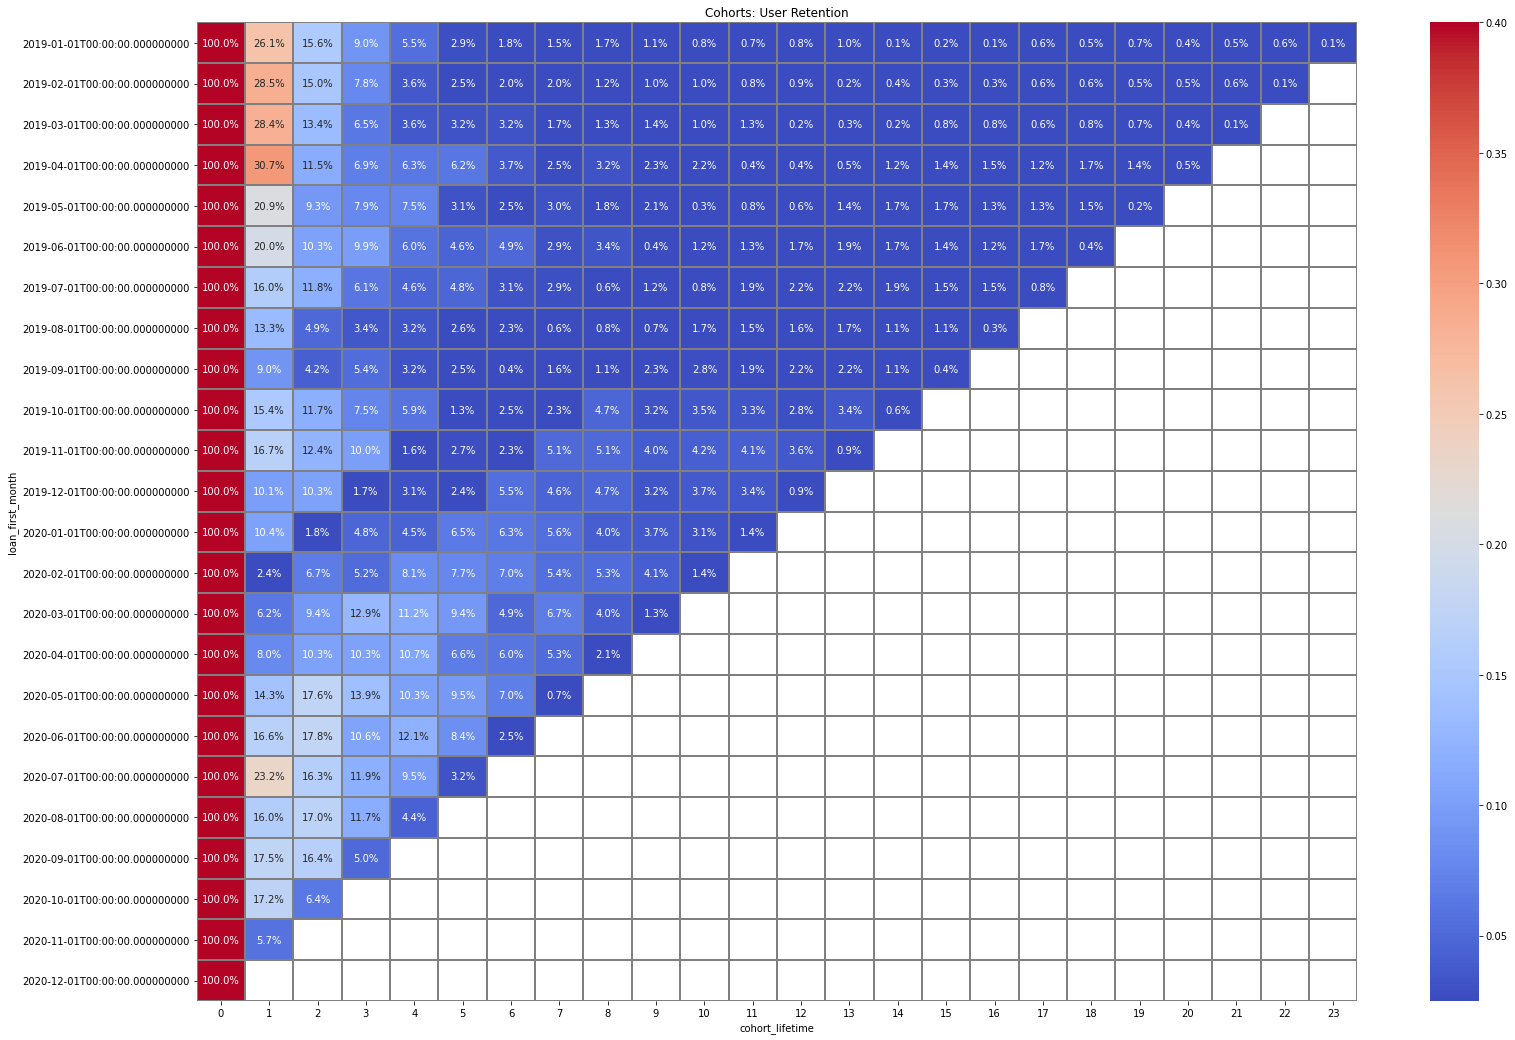

In [58]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmax=0.4, vmin=0.025);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>в начале и середине 2019 года мы видим достаточно хороший ретеншен в месяцах 0-1-2
        <li>затем, примерно в авгуте 2019 показатели стали ухудшаться и ретеншен 1 месяца опустился до 20%, а затем и вовсе до 15%
        <li>однако сейчас снова наблюдается рост, начиная с мая 2020
    </ul>
</div>

#### 5.2 Среднее кол-во займов

In [59]:
avg_loan_amount = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).reset_index()
avg_loan_amount.rename(columns={'cid': 'cumsum_loans'}, inplace=True)
avg_loan_amount = pd.merge(avg_loan_amount, initial_users, on='loan_first_month')
avg_loan_amount['avg_loans'] = (avg_loan_amount['cumsum_loans'] / avg_loan_amount['initial_users']).round(2)

avg_loan_amount.head()

,loan_first_month,cohort_lifetime,cumsum_loans,initial_users,avg_loans
0,2019-01-01,0,5434,4540,1.20
1,2019-01-01,1,1426,4540,0.31
2,2019-01-01,2,826,4540,0.18
3,2019-01-01,3,486,4540,0.11
4,2019-01-01,4,289,4540,0.06


In [60]:
avg_loan_pivot = avg_loan_amount.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='avg_loans', aggfunc='mean').cumsum(axis=1)

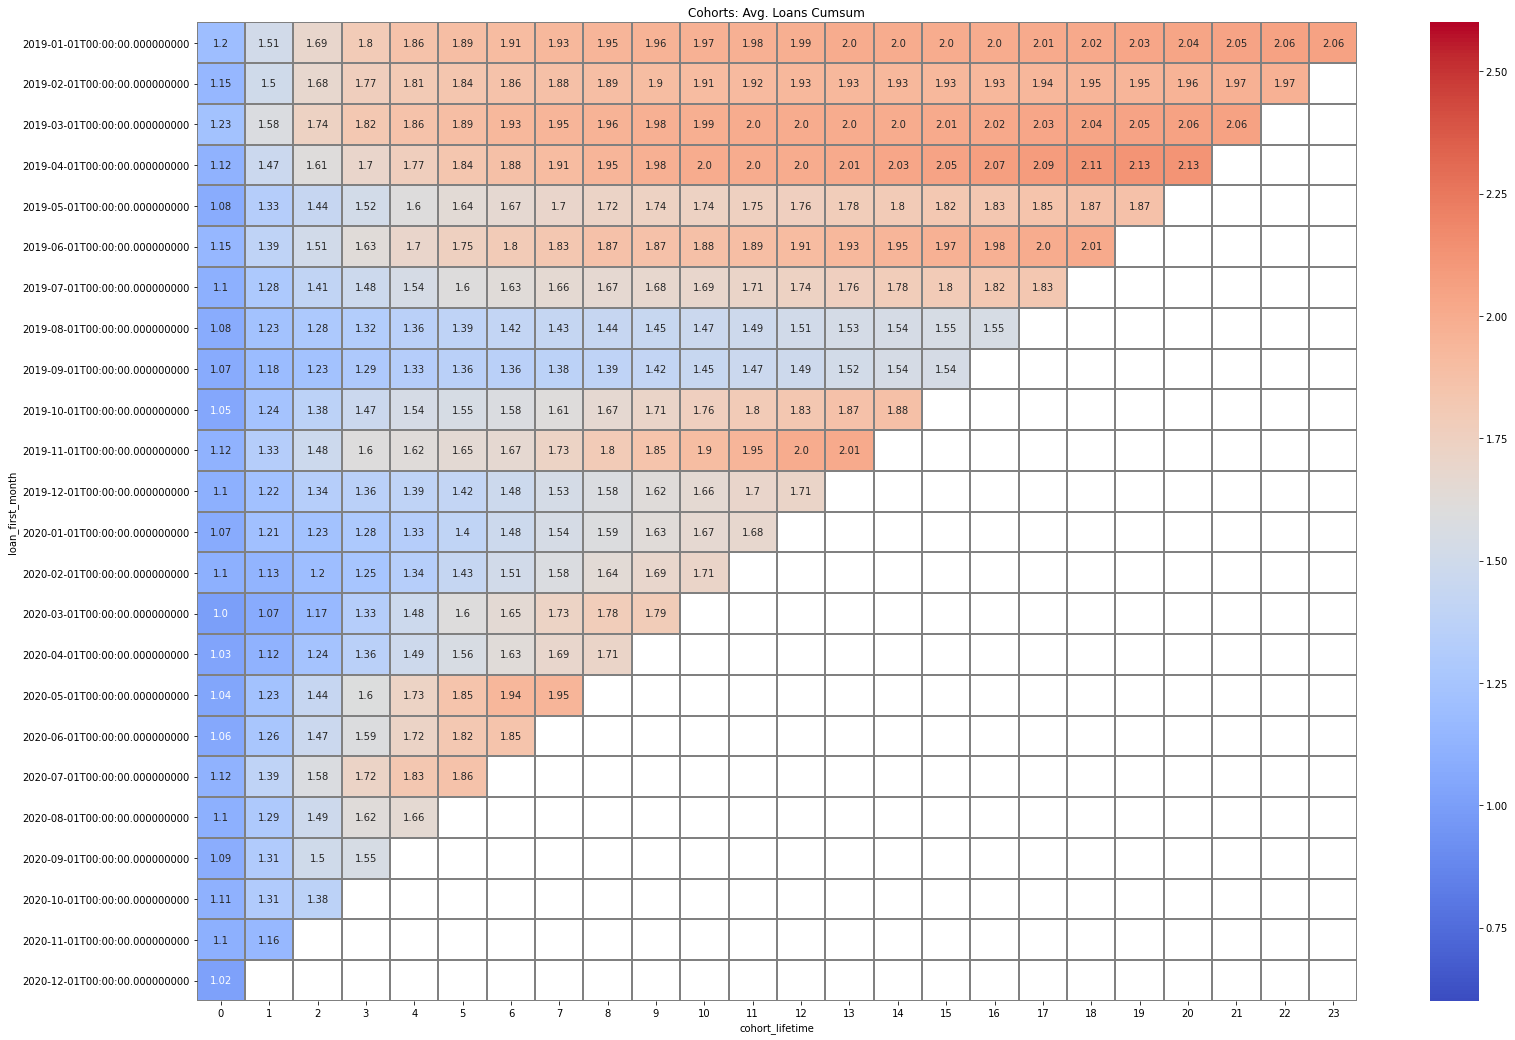

In [61]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Avg. Loans Cumsum')
sns.heatmap(avg_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.6, vmax=2.6);

#### 5.3 ARPU (Average Revenue per User)

In [62]:
arpu = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum'}).reset_index()
arpu = pd.merge(arpu, initial_users, on='loan_first_month')
arpu['arpu'] = ((arpu['value'] / arpu['initial_users'])/1000).round(2)

arpu.head()

,loan_first_month,cohort_lifetime,value,initial_users,arpu
0,2019-01-01,0,57294800.0,4540,12.62
1,2019-01-01,1,17426400.0,4540,3.84
2,2019-01-01,2,11066000.0,4540,2.44
3,2019-01-01,3,6522700.0,4540,1.44
4,2019-01-01,4,3894910.8,4540,0.86


In [63]:
arpu_pivot = arpu.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='arpu', aggfunc='mean').cumsum(axis=1)

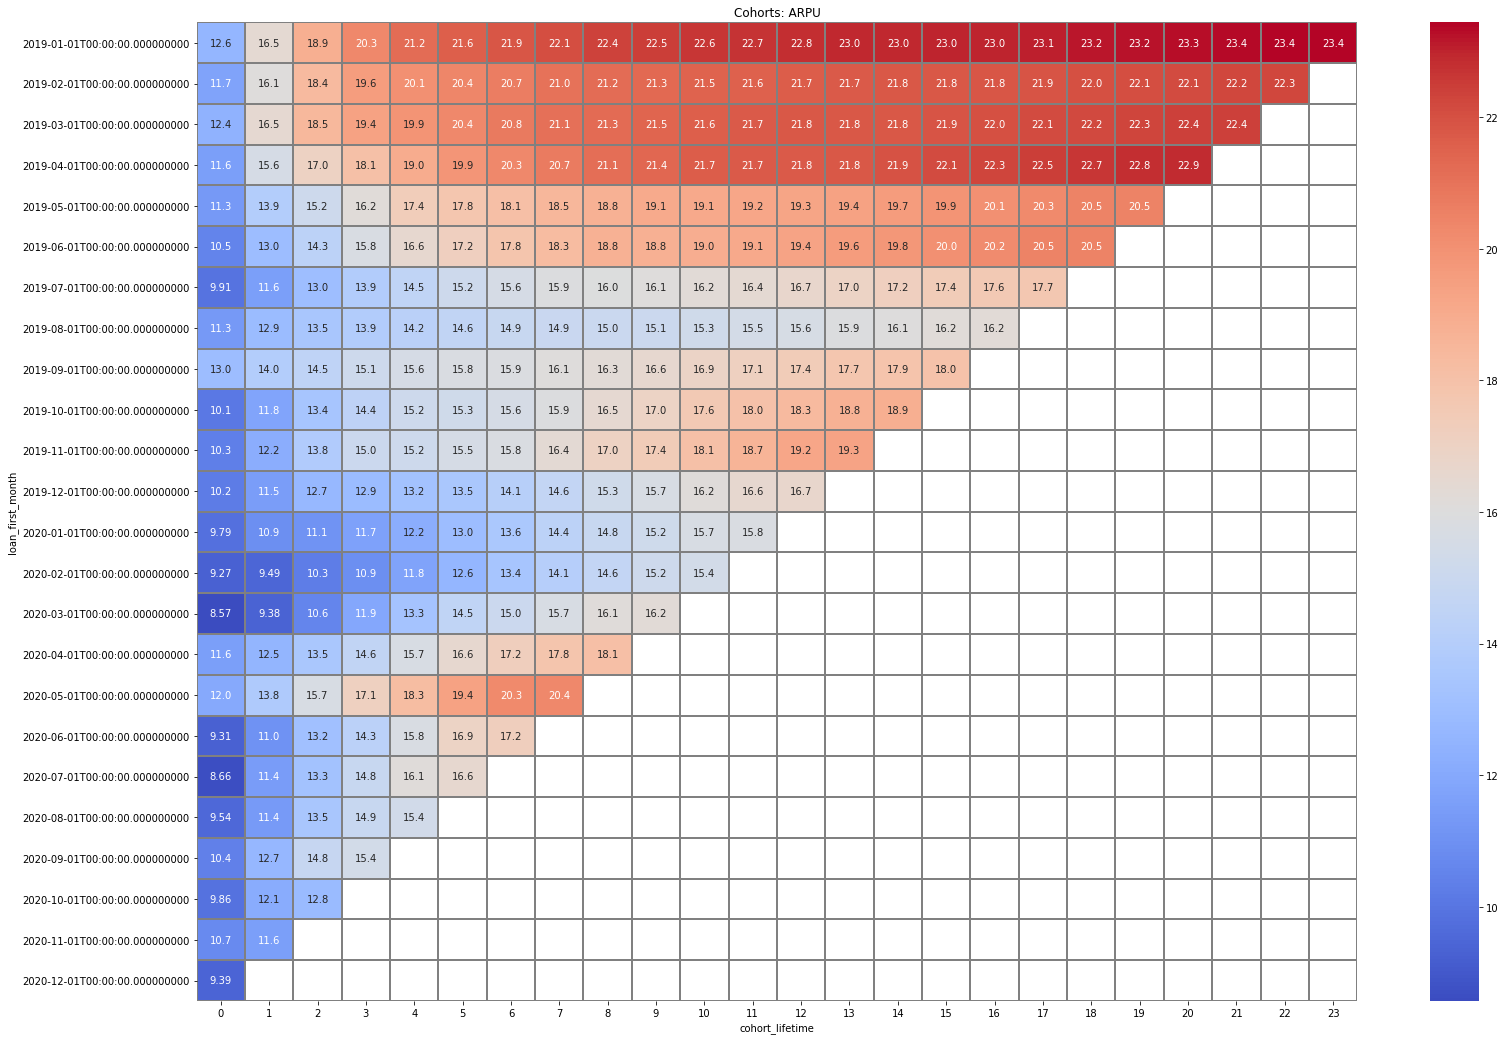

In [64]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: ARPU')
sns.heatmap(arpu_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm');

#### 5.4 Средняя сумма займа в конкретный месяц
почему с ростом lifetime "чек" не растет?

In [65]:
avg_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'}).reset_index()
avg_loan_value['avg_loan_value'] = ((avg_loan_value['value'] / avg_loan_value['cid'])/1000).round(2)

avg_loan_value.head()

,loan_first_month,cohort_lifetime,value,cid,avg_loan_value
0,2019-01-01,0,57294800.0,5434,10.54
1,2019-01-01,1,17426400.0,1426,12.22
2,2019-01-01,2,11066000.0,826,13.40
3,2019-01-01,3,6522700.0,486,13.42
4,2019-01-01,4,3894910.8,289,13.48


In [66]:
avg_loan_value_pivot = avg_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_loan_value', aggfunc='mean')

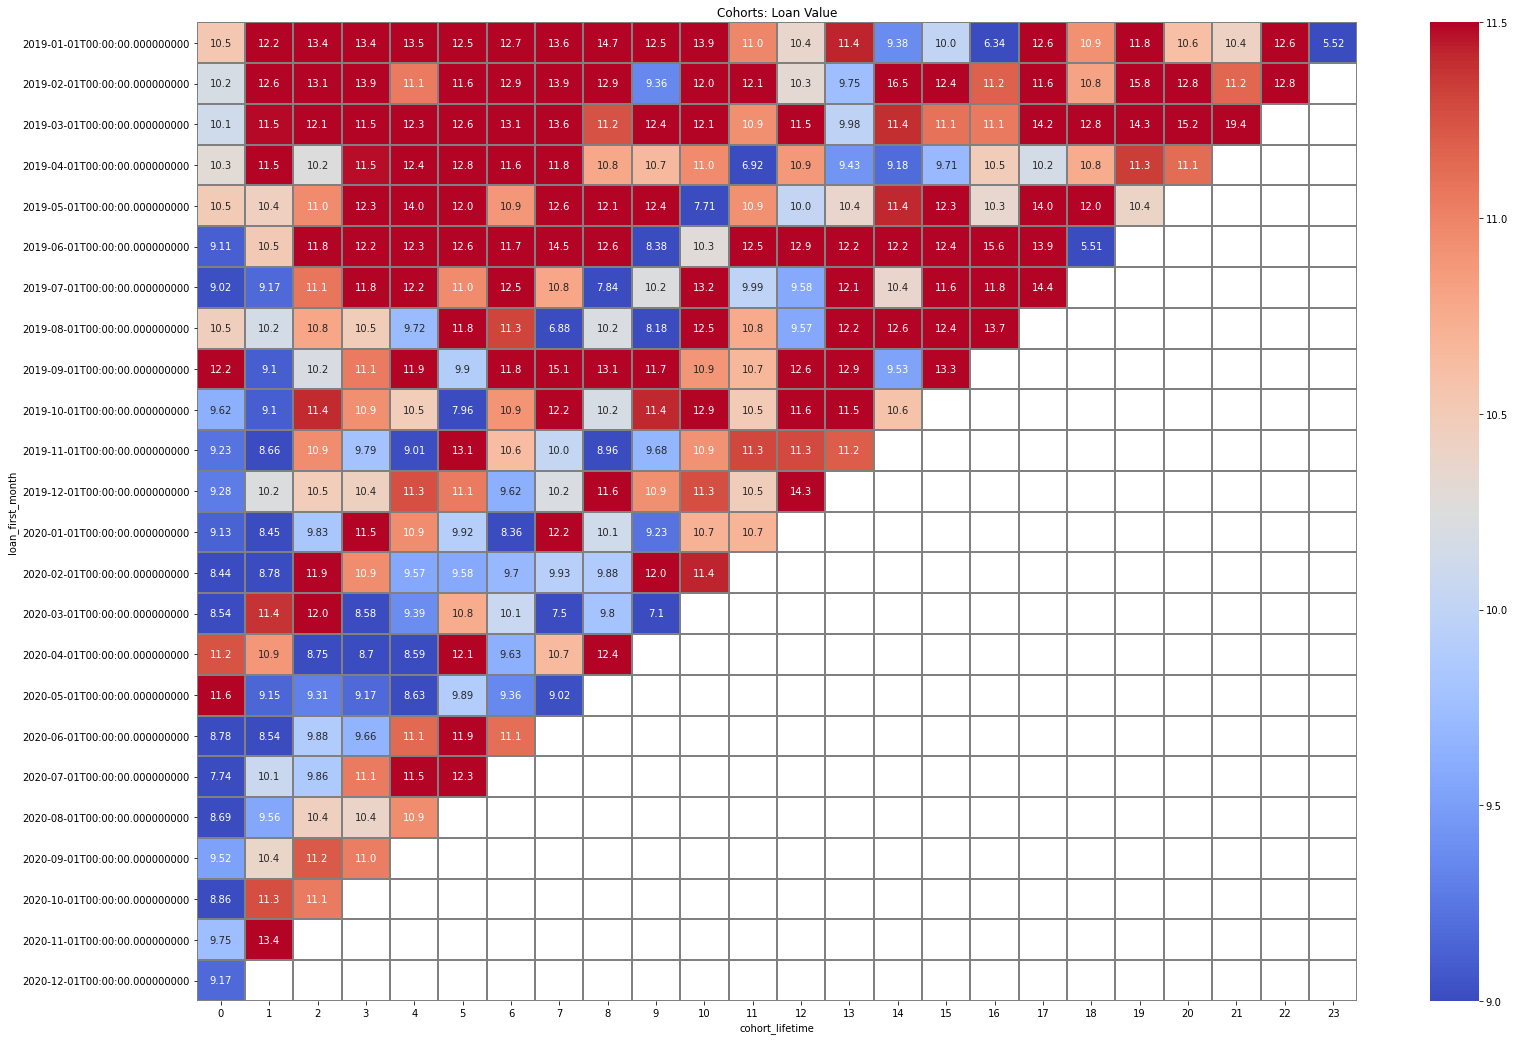

In [67]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_loan_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=9, vmax=11.5);

#### 5.4 Средняя сумма займа накопительным итогом

In [68]:
avg_cumsum_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'})\
.groupby(level=0).cumsum().reset_index()
avg_cumsum_loan_value.rename(columns={'value': 'cumsum_value', 'cid': 'cumsum_loans'}, inplace=True)
avg_cumsum_loan_value['avg_cumsum_loan_value'] = ((avg_cumsum_loan_value['cumsum_value'] / avg_cumsum_loan_value['cumsum_loans'])/1000).round(2)

avg_cumsum_loan_value.head()

,loan_first_month,cohort_lifetime,cumsum_value,cumsum_loans,avg_cumsum_loan_value
0,2019-01-01,0,57294800.0,5434,10.54
1,2019-01-01,1,74721200.0,6860,10.89
2,2019-01-01,2,85787200.0,7686,11.16
3,2019-01-01,3,92309900.0,8172,11.30
4,2019-01-01,4,96204810.8,8461,11.37


In [69]:
avg_cumsum_loan_pivot = avg_cumsum_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_cumsum_loan_value', aggfunc='mean')

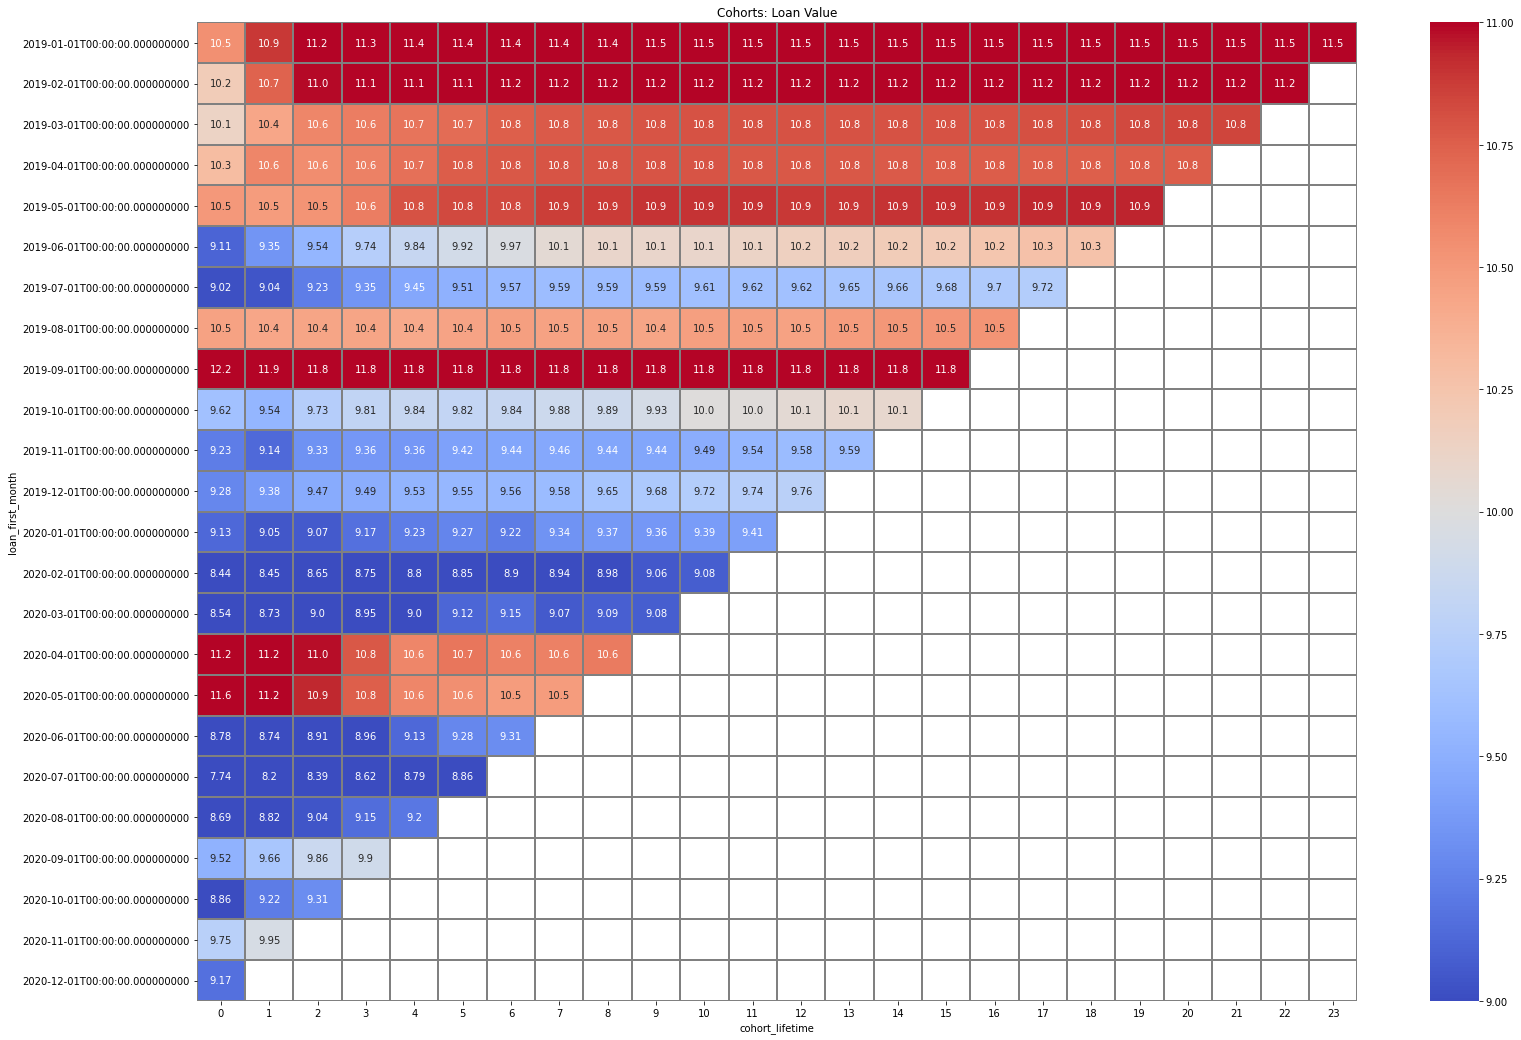

In [70]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_cumsum_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=9, vmax=11);

#### 5.5 Оборотка нарастающим итогом

In [71]:
cumsum_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', }).reset_index()
cumsum_value['value'] = (cumsum_value['value'] / 10000000).round(2)

cumsum_value

,loan_first_month,cohort_lifetime,value
0,2019-01-01,0,5.73
1,2019-01-01,1,1.74
2,2019-01-01,2,1.11
3,2019-01-01,3,0.65
4,2019-01-01,4,0.39
...,...,...,...
295,2020-10-01,1,0.21
296,2020-10-01,2,0.07
297,2020-11-01,0,0.64
298,2020-11-01,1,0.05


In [72]:
initial_value = cumsum_value[cumsum_value['cohort_lifetime'] == 0][['loan_first_month', 'value']]
initial_value.columns=['loan_first_month', 'initial_value']
initial_value

,loan_first_month,initial_value
0,2019-01-01,5.73
24,2019-02-01,5.83
47,2019-03-01,3.70
69,2019-04-01,3.51
90,2019-05-01,2.81
110,2019-06-01,1.46
129,2019-07-01,3.18
147,2019-08-01,2.10
164,2019-09-01,1.75
180,2019-10-01,1.30


In [73]:
cumsum_value = pd.merge(cumsum_value, initial_value, on='loan_first_month')
cumsum_value['value_gain'] = cumsum_value['value'] / cumsum_value['initial_value']

cumsum_value.head(20)

,loan_first_month,cohort_lifetime,value,initial_value,value_gain
0,2019-01-01,0,5.73,5.73,1.000000
1,2019-01-01,1,1.74,5.73,0.303665
2,2019-01-01,2,1.11,5.73,0.193717
3,2019-01-01,3,0.65,5.73,0.113438
4,2019-01-01,4,0.39,5.73,0.068063
5,2019-01-01,5,0.18,5.73,0.031414
6,2019-01-01,6,0.12,5.73,0.020942
7,2019-01-01,7,0.10,5.73,0.017452
8,2019-01-01,8,0.12,5.73,0.020942
9,2019-01-01,9,0.07,5.73,0.012216


In [74]:
cumsum_value_pivot = cumsum_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                         values='value_gain', aggfunc='mean').cumsum(axis=1)

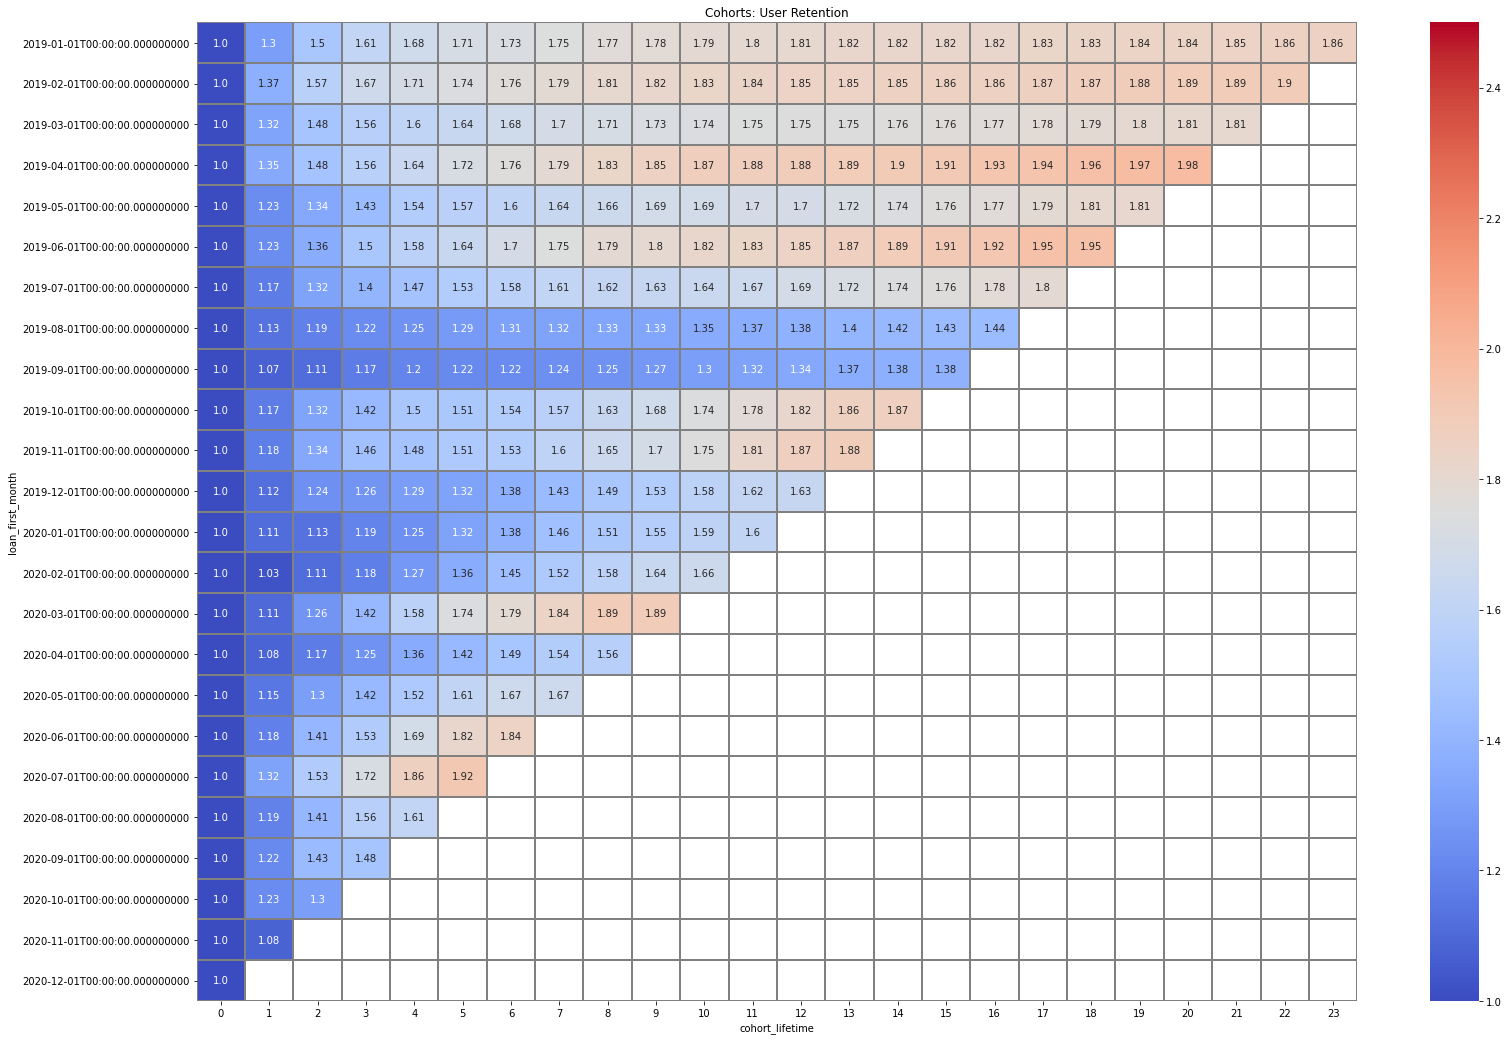

In [75]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(cumsum_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmax=2.5);

In [76]:
loans['end_month'] = loans['end_ts'].astype('datetime64[M]')
loans.head()

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term,term_category,loan_first_month,cohort_lifetime,end_month
0,888862,2019-01-01,5000.0,30,Погашен,2019-01-02,2019-01-01,2018-12-31,2019-01-01,1.0,Досрочно,2019-01-01,0,2019-01-01
1,888862,2019-01-13,2500.0,7,Погашен,2019-01-13,2019-01-13,2019-01-07,2019-01-01,0.0,Досрочно,2019-01-01,0,2019-01-01
2,888862,2019-01-14,2500.0,30,Погашен,2019-01-31,2019-01-14,2019-01-14,2019-01-01,17.0,Досрочно,2019-01-01,0,2019-01-01
3,888862,2019-02-12,4700.0,30,Погашен,2019-02-15,2019-02-12,2019-02-11,2019-02-01,3.0,Досрочно,2019-01-01,1,2019-02-01
4,888862,2019-02-18,3000.0,30,Погашен,2019-02-21,2019-02-18,2019-02-18,2019-02-01,3.0,Досрочно,2019-01-01,1,2019-02-01


In [77]:
get_loans = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
get_loans.rename(columns={'cid': 'get_loans'}, inplace=True)
get_loans.head()

,loan_first_month,cohort_lifetime,get_loans
0,2019-01-01,0,5434
1,2019-01-01,1,6860
2,2019-01-01,2,7686
3,2019-01-01,3,8172
4,2019-01-01,4,8461


In [78]:
paid_loans = loans.groupby(['loan_first_month', 'end_month']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
paid_loans['cohort_lifetime'] = ((paid_loans['end_month'] - paid_loans['loan_first_month']) / np.timedelta64(1,'M')).round().astype('int')
paid_loans.drop(columns='end_month', inplace=True)
paid_loans = paid_loans[['loan_first_month', 'cohort_lifetime', 'cid']]
paid_loans.rename(columns={'cid': 'paid_loans'}, inplace=True)

paid_loans.head()

,loan_first_month,cohort_lifetime,paid_loans
0,2019-01-01,0,1333
1,2019-01-01,1,3227
2,2019-01-01,2,4211
3,2019-01-01,3,4779
4,2019-01-01,4,5098


In [79]:
output = pd.merge(get_loans, paid_loans, on=['loan_first_month', 'cohort_lifetime'])
output['r_rate'] = output['paid_loans'] / output['get_loans']
output_pivot = output.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='r_rate')

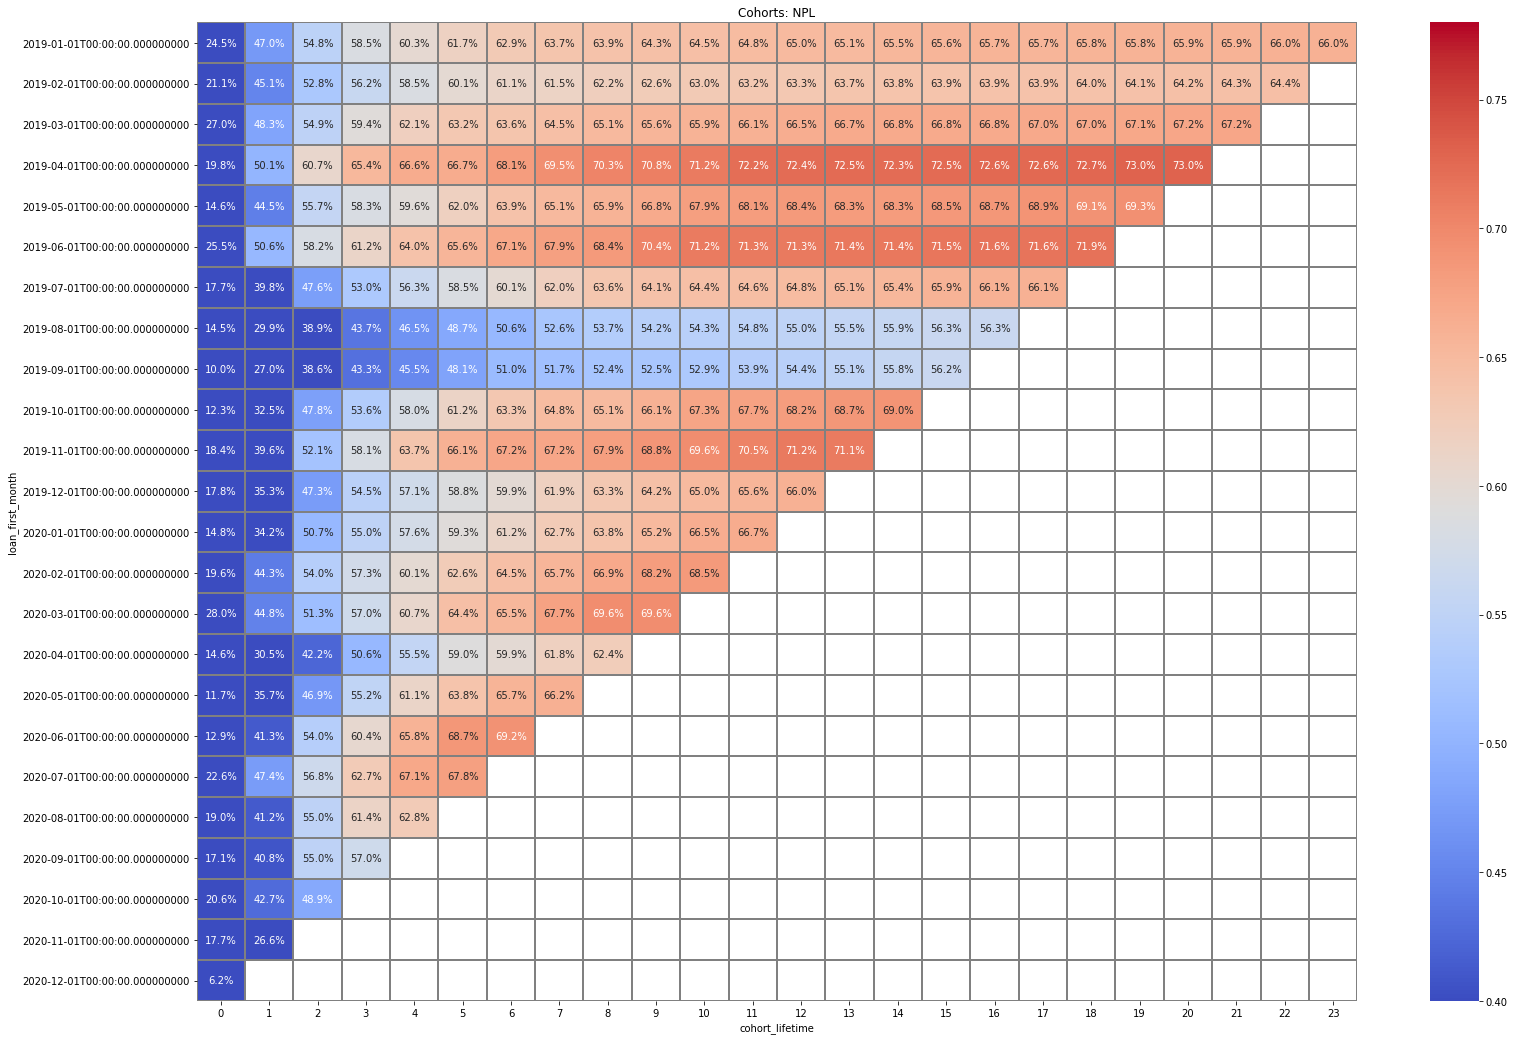

In [80]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: NPL')
sns.heatmap(output_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.4, vmax=0.78);